In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (8,5)})
plt.style.use("default")

EXP_PATH = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_experiment_clients.txt"
ZIP_PATH  = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_web_data_pt_.zip"
EXTRACT_DIR = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/webdata_extracted"
DEMO_PATH = "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/df_final_demo.txt"

plt.style.use("default")
plt.rcParams.update({"figure.figsize": (8, 5)})

# ==========================================================
# 1) Load Experiment & Web Logs, attach Variation
# ==========================================================

df_exp = pd.read_csv(EXP_PATH)
df_exp = df_exp[df_exp["Variation"].isin(["Test","Control"])].copy()

os.makedirs(EXTRACT_DIR, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(EXTRACT_DIR)

web_files = [f for f in os.listdir(EXTRACT_DIR) if f.endswith(".txt")]
frames = [pd.read_csv(os.path.join(EXTRACT_DIR, f), parse_dates=["date_time"]) for f in web_files]
dw = pd.concat(frames, ignore_index=True)

dw = dw.merge(df_exp, on="client_id", how="inner")
dw = dw[dw["Variation"].isin(["Test","Control"])].copy()

print("Web events (rows):", len(dw))
print("Unique visitors:", dw["visitor_id"].nunique())
print("Unique visits:", dw["visit_id"].nunique())
print("Process steps:", sorted(dw["process_step"].unique()))


Web events (rows): 321309
Unique visitors: 56011
Unique visits: 69205
Process steps: ['confirm', 'start', 'step_1', 'step_2', 'step_3']


In [2]:
# ==========================================================
# 2) Identify visitors present in BOTH variations.
# ==========================================================
variation_per_visitor = dw.groupby("visitor_id")["Variation"].nunique()
dual_visitors = variation_per_visitor[variation_per_visitor == 2].index
dw_dual = dw[dw["visitor_id"].isin(dual_visitors)].copy()

print("Visitors in both groups:", len(dual_visitors))
print("Rows after filtering:", len(dw_dual))

Visitors in both groups: 185
Rows after filtering: 2321


In [3]:
# ==========================================================
# 3) Compute per-visit durations using FIRST occurrence of each step
# ==========================================================
STEP_ORDER = ["start", "step_1", "step_2", "step_3", "confirm"]

dw_dual_sorted = dw_dual.sort_values(["visit_id", "date_time"])
first_step_time = (
    dw_dual_sorted
    .drop_duplicates(subset=["visit_id", "process_step"], keep="first")
    .pivot_table(index=["visit_id", "visitor_id", "client_id", "Variation"],
                 columns="process_step", values="date_time", aggfunc="first")
    .reset_index()
)

for s in STEP_ORDER:
    if s not in first_step_time.columns:
        first_step_time[s] = pd.NaT

def minutes_between(a, b):
    if pd.isna(a) or pd.isna(b):
        return np.nan
    return (b - a).total_seconds() / 60.0

per_visit = first_step_time.copy()
per_visit["t_start_to_step_1"]   = per_visit.apply(lambda r: minutes_between(r.get("start"),   r.get("step_1")),   axis=1)
per_visit["t_step_1_to_step_2"]  = per_visit.apply(lambda r: minutes_between(r.get("step_1"),  r.get("step_2")),  axis=1)
per_visit["t_step_2_to_step_3"]  = per_visit.apply(lambda r: minutes_between(r.get("step_2"),  r.get("step_3")),  axis=1)
per_visit["t_step_3_to_confirm"] = per_visit.apply(lambda r: minutes_between(r.get("step_3"),  r.get("confirm")), axis=1)
per_visit["t_start_to_confirm"]  = per_visit.apply(lambda r: minutes_between(r.get("start"),   r.get("confirm")), axis=1)
per_visit["completed"]           = per_visit["confirm"].notna().astype(int)

per_visit.head()



process_step,visit_id,visitor_id,client_id,Variation,confirm,start,step_1,step_2,step_3,t_start_to_step_1,t_step_1_to_step_2,t_step_2_to_step_3,t_step_3_to_confirm,t_start_to_confirm,completed
0,102039130_96083762708_562998,494497404_19580991399,1688588,Test,2017-05-29 14:38:10,2017-05-29 14:33:38,2017-05-29 14:33:44,2017-05-29 14:35:20,2017-05-29 14:37:16,0.100000,1.600000,1.933333,0.900000,4.533333,1
1,103844930_39480104147_119972,254175251_5339168232,1295824,Test,2017-04-14 16:25:28,2017-04-14 16:20:52,2017-04-14 16:22:04,2017-04-14 16:24:00,2017-04-14 16:24:34,1.200000,1.933333,0.566667,0.900000,4.600000,1
2,10556427_59314261366_450199,136361015_51931191096,2886145,Test,2017-04-05 11:23:42,2017-04-05 11:20:36,2017-04-05 11:21:10,2017-04-05 11:21:52,2017-04-05 11:23:06,0.566667,0.700000,1.233333,0.600000,3.100000,1
3,107090185_43642799759_974372,667315159_68457727652,823619,Test,2017-04-03 18:37:17,2017-04-03 18:35:37,2017-04-03 18:36:01,2017-04-03 18:36:21,2017-04-03 18:36:52,0.400000,0.333333,0.516667,0.416667,1.666667,1
4,11081880_55901769447_75033,851864656_64225757002,9779291,Test,NaT,2017-03-19 15:50:43,2017-03-19 15:50:54,NaT,NaT,0.183333,NaN,NaN,NaN,NaN,0


In [4]:
# ==========================================================
# 4) Aggregate per-visitor means within each Variation
# ==========================================================
agg_cols = [
    "t_start_to_step_1",
    "t_step_1_to_step_2",
    "t_step_2_to_step_3",
    "t_step_3_to_confirm",
    "t_start_to_confirm",
    "completed"
]

per_visitor_var = (
    per_visit
    .groupby(["visitor_id","Variation"], as_index=False)[agg_cols]
    .mean()
)

per_visitor_var.head()


process_step,visitor_id,Variation,t_start_to_step_1,t_step_1_to_step_2,t_step_2_to_step_3,t_step_3_to_confirm,t_start_to_confirm,completed
0,100636834_70620124872,Test,0.191667,0.583333,1.200000,0.666667,2.566667,0.5
1,101002710_46550496480,Control,0.150000,0.200000,4.483333,0.933333,5.766667,0.5
2,105986634_15115236135,Test,0.233333,0.333333,1.200000,0.766667,2.533333,1.0
3,123678861_93517709373,Control,0.500000,0.400000,0.666667,3.483333,5.050000,1.0
4,123678861_93517709373,Test,0.116667,0.366667,2.750000,1.400000,4.633333,1.0


In [5]:

# ==========================================================
# 5) Pair Test vs Control within SAME visitor_id
# ==========================================================
pv = per_visitor_var.pivot(index="visitor_id", columns="Variation", values=agg_cols)
pv.columns = [f"{col[0]}__{col[1].lower()}" for col in pv.columns]
pv = pv.reset_index()

for c in agg_cols:
    pv[f"{c}__delta_test_minus_control"] = pv.get(f"{c}__test") - pv.get(f"{c}__control")

pv.head()


,visitor_id,t_start_to_step_1__control,t_start_to_step_1__test,t_step_1_to_step_2__control,t_step_1_to_step_2__test,t_step_2_to_step_3__control,t_step_2_to_step_3__test,t_step_3_to_confirm__control,t_step_3_to_confirm__test,t_start_to_confirm__control,t_start_to_confirm__test,completed__control,completed__test,t_start_to_step_1__delta_test_minus_control,t_step_1_to_step_2__delta_test_minus_control,t_step_2_to_step_3__delta_test_minus_control,t_step_3_to_confirm__delta_test_minus_control,t_start_to_confirm__delta_test_minus_control,completed__delta_test_minus_control
0,100636834_70620124872,NaN,0.191667,NaN,0.583333,NaN,1.20,NaN,0.666667,NaN,2.566667,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN
1,101002710_46550496480,0.150000,NaN,0.200000,NaN,4.483333,NaN,0.933333,NaN,5.766667,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,105986634_15115236135,NaN,0.233333,NaN,0.333333,NaN,1.20,NaN,0.766667,NaN,2.533333,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,123678861_93517709373,0.500000,0.116667,0.400000,0.366667,0.666667,2.75,3.483333,1.400000,5.050000,4.633333,1.0,1.0,-0.383333,-0.033333,2.083333,-2.083333,-0.416667,0.0
4,124364695_72848638784,0.066667,4.116667,0.116667,NaN,1.233333,NaN,0.666667,NaN,2.083333,NaN,1.0,0.0,4.050000,NaN,NaN,NaN,NaN,-1.0


In [7]:
# ==========================================================
# 6) Summarize deltas across visitors
# ==========================================================
def summarize_delta(series, name):
    s = pd.to_numeric(series, errors="coerce").dropna()
    return {
        "metric": name,
        "n": int(s.shape[0]),
        "mean_delta": float(np.mean(s)) if len(s)>0 else np.nan,
        "median_delta": float(np.median(s)) if len(s)>0 else np.nan,
        "std": float(np.std(s, ddof=1)) if len(s)>1 else np.nan,
        "p25": float(np.percentile(s, 25)) if len(s)>0 else np.nan,
        "p75": float(np.percentile(s, 75)) if len(s)>0 else np.nan,
        "min": float(np.min(s)) if len(s)>0 else np.nan,
        "max": float(np.max(s)) if len(s)>0 else np.nan,
    }

delta_rows = []
for c in agg_cols:
    delta_col = f"{c}__delta_test_minus_control"
    if delta_col in pv.columns:
        delta_rows.append(summarize_delta(pv[delta_col], c))

delta_summary = pd.DataFrame(delta_rows)
delta_summary



,metric,n,mean_delta,median_delta,std,p25,p75,min,max
0,t_start_to_step_1,60,-0.962222,-0.108333,3.875671,-0.383333,0.033333,-24.616667,4.050000
1,t_step_1_to_step_2,56,0.503571,0.100000,1.991993,-0.154167,0.462500,-1.733333,12.750000
2,t_step_2_to_step_3,56,0.104315,-0.108333,1.504792,-0.687500,0.287500,-3.083333,6.316667
3,t_step_3_to_confirm,50,-1.156000,-0.970833,3.693667,-1.512500,-0.035417,-23.166667,5.783333
4,t_start_to_confirm,48,-1.753472,-0.683333,6.234858,-4.175000,1.641667,-24.650000,11.383333
5,completed,85,0.098039,0.000000,0.513890,0.000000,0.000000,-1.000000,1.000000


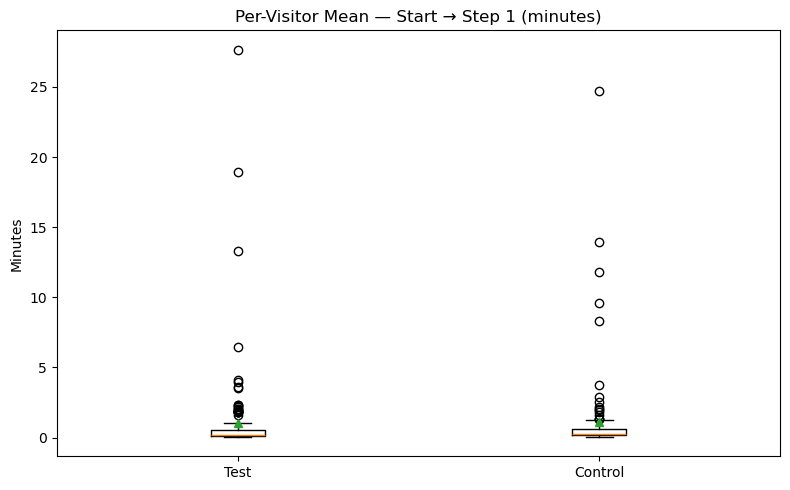

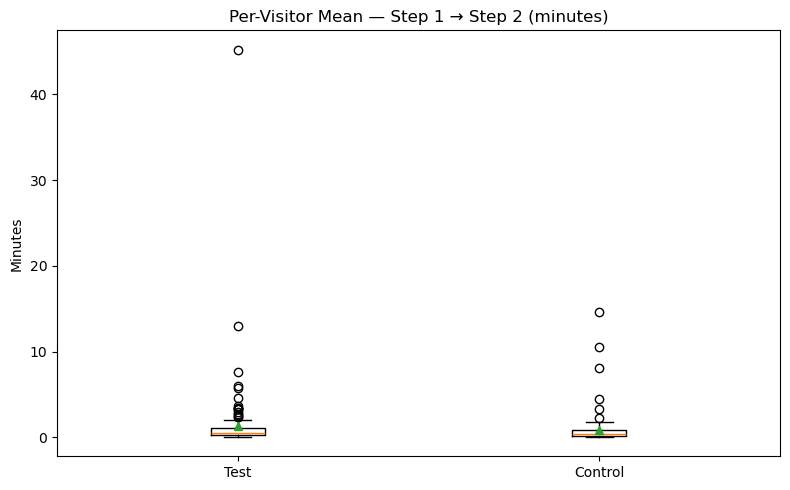

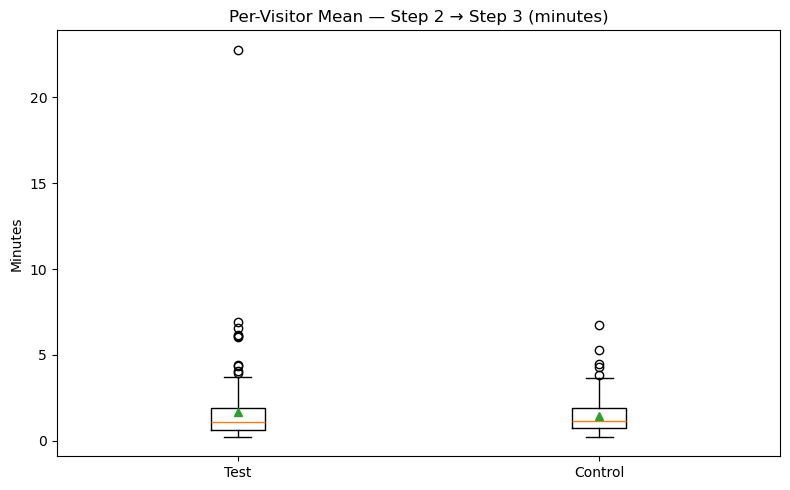

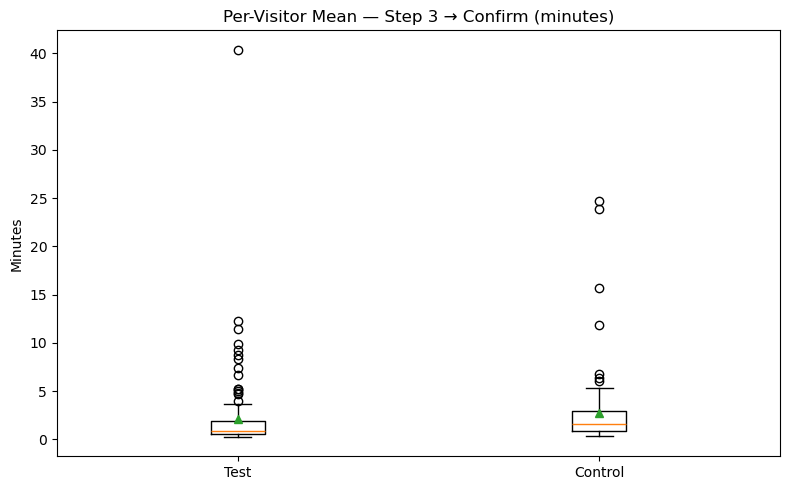

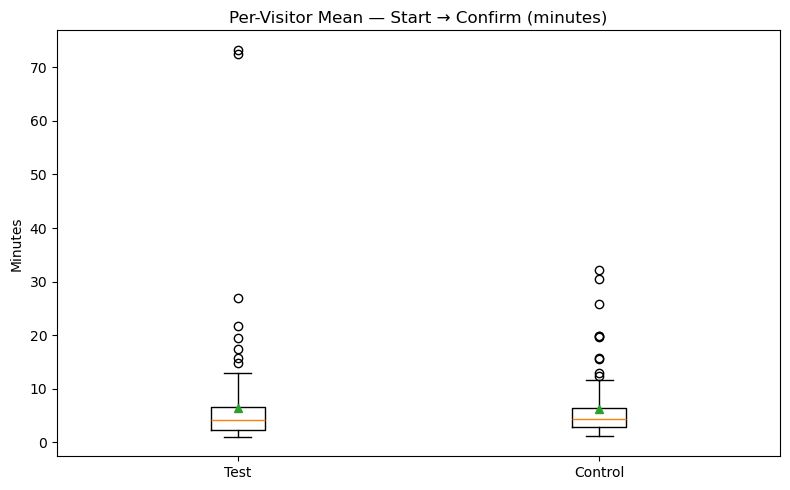

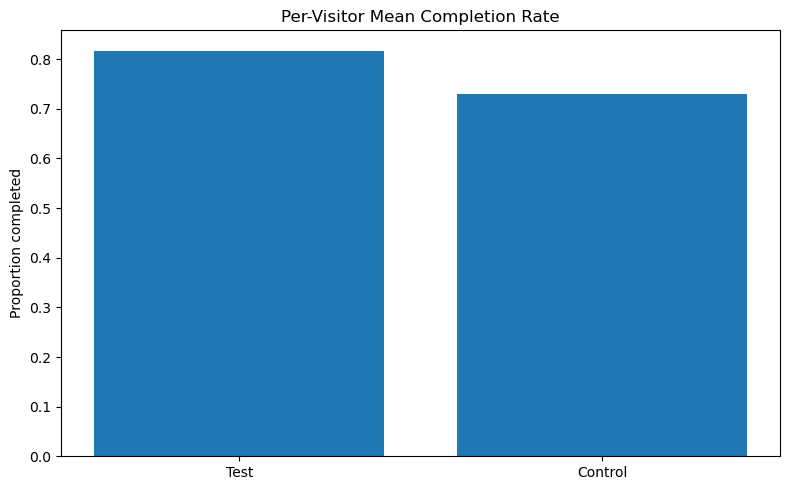

In [8]:
# ==========================================================
# 7) Visualizations — Per-Visitor Means
# ==========================================================
def boxplot_two(series_a, series_b, labels, title, ylabel):
    a = pd.to_numeric(series_a, errors="coerce").dropna()
    b = pd.to_numeric(series_b, errors="coerce").dropna()
    plt.figure()
    plt.boxplot([a, b], labels=labels, showmeans=True)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

pairs = [
    ("t_start_to_step_1",  "Start → Step 1 (minutes)"),
    ("t_step_1_to_step_2", "Step 1 → Step 2 (minutes)"),
    ("t_step_2_to_step_3", "Step 2 → Step 3 (minutes)"),
    ("t_step_3_to_confirm","Step 3 → Confirm (minutes)"),
    ("t_start_to_confirm", "Start → Confirm (minutes)"),
]

for metric, title in pairs:
    test_col = f"{metric}__test"
    ctrl_col = f"{metric}__control"
    if test_col in pv.columns and ctrl_col in pv.columns:
        boxplot_two(pv[test_col], pv[ctrl_col],
                    ["Test","Control"],
                    f"Per-Visitor Mean — {title}",
                    "Minutes")

# Completion rate (per-visitor mean)
if "completed__test" in pv.columns and "completed__control" in pv.columns:
    plt.figure()
    vals = [
        pd.to_numeric(pv["completed__test"], errors="coerce").mean(),
        pd.to_numeric(pv["completed__control"], errors="coerce").mean()
    ]
    plt.bar(["Test","Control"], vals)
    plt.title("Per-Visitor Mean Completion Rate")
    plt.ylabel("Proportion completed")
    plt.tight_layout()
    plt.show()


In [9]:
df_visitor = pd.read_csv(
    "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/per_visitor_paired_test_control_ MAYBE_NOT_USE.csv")
df_visitor

,visitor_id,t_start_to_step_1__control,t_start_to_step_1__test,t_step_1_to_step_2__control,t_step_1_to_step_2__test,t_step_2_to_step_3__control,t_step_2_to_step_3__test,t_step_3_to_confirm__control,t_step_3_to_confirm__test,t_start_to_confirm__control,t_start_to_confirm__test,completed__control,completed__test,t_start_to_step_1__delta_test_minus_control,t_step_1_to_step_2__delta_test_minus_control,t_step_2_to_step_3__delta_test_minus_control,t_step_3_to_confirm__delta_test_minus_control,t_start_to_confirm__delta_test_minus_control,completed__delta_test_minus_control
0,100636834_70620124872,NaN,0.191667,NaN,0.583333,NaN,1.200000,NaN,0.666667,NaN,2.566667,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN
1,101002710_46550496480,0.150000,NaN,0.200000,NaN,4.483333,NaN,0.933333,NaN,5.766667,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,105986634_15115236135,NaN,0.233333,NaN,0.333333,NaN,1.200000,NaN,0.766667,NaN,2.533333,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,123678861_93517709373,0.500000,0.116667,0.400000,0.366667,0.666667,2.750000,3.483333,1.400000,5.050000,4.633333,1.0,1.0,-0.383333,-0.033333,2.083333,-2.083333,-0.416667,0.0
4,124364695_72848638784,0.066667,4.116667,0.116667,NaN,1.233333,NaN,0.666667,NaN,2.083333,NaN,1.0,0.0,4.050000,NaN,NaN,NaN,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180,989197874_24115340213,2.200000,0.166667,0.116667,0.433333,0.600000,0.783333,1.400000,0.450000,4.316667,1.833333,1.0,1.0,-2.033333,0.316667,0.183333,-0.950000,-2.483333,0.0
181,993860627_38915998531,0.208333,0.241667,NaN,0.391667,NaN,6.133333,NaN,NaN,NaN,NaN,0.0,0.0,0.033333,NaN,NaN,NaN,NaN,0.0
182,994556188_95260212644,0.366667,NaN,0.533333,NaN,0.883333,NaN,1.633333,NaN,3.416667,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
183,995658764_57249134716,NaN,0.150000,NaN,0.683333,NaN,1.766667,NaN,4.650000,NaN,7.250000,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
df_visitor_summary = pd.read_csv(
    "/home/rafael/Área de Trabalho/CUROS IRONHACK/SEMANA 6/PROJETO 2/vanguard-ab-test/data/raw/per_visitor_delta_summary_ MAYBE_NOT_USE.csv")
df_visitor_summary

,metric,n,mean_delta,median_delta,std,p25,p75,min,max
0,t_start_to_step_1,60,-0.962222,-0.108333,3.875671,-0.383333,0.033333,-24.616667,4.050000
1,t_step_1_to_step_2,56,0.503571,0.100000,1.991993,-0.154167,0.462500,-1.733333,12.750000
2,t_step_2_to_step_3,56,0.104315,-0.108333,1.504792,-0.687500,0.287500,-3.083333,6.316667
3,t_step_3_to_confirm,50,-1.156000,-0.970833,3.693667,-1.512500,-0.035417,-23.166667,5.783333
4,t_start_to_confirm,48,-1.753472,-0.683333,6.234858,-4.175000,1.641667,-24.650000,11.383333
5,completed,85,0.098039,0.000000,0.513890,0.000000,0.000000,-1.000000,1.000000
